**먼저 모듈 설치하기**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-rc1
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64




---

**numpy를 사용해 csv파일 불러오기**





In [33]:
import numpy as np

rows = np.loadtxt("./lotto.csv", delimiter=",")
row_count = len(rows) # 데이터 수
print(row_count)

1031


**숫자 <--> 원핫인코딩벡터 변환함수 정의하기**


In [34]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

딥러닝의 데이터 셋을 구성할 때는 성능을 검증하기 위해서
보통 훈련셋/ 검증셋/ 시험셋으로 분리를 해서 구성한다.  

In [35]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 900), test: (901, 1030)



**모델 구성 - LSTM (RNN 계열)**

시계열 데이터(시간에 따른 데이터), 자연어 데이터 처리 등(이전 데이터가 다음 데이터에 영향을 줌)에 사용되는 딥러닝 모델

여기서 로또번호가 이전번호가 다음 번호에 영향을 준다고 가정하자.
<br/><br/>

**모델 입출력 정의 - 지도학습**

지도학습은 문제와 정답을 줘서 모델을 학습을 시켜는 방식으로 이전 회차 당첨 번호를 문제로 주고 다음 회차 당첨 번호를 정답으로 줘서 이전과 다음이 이렇게 연관이 있다는 것을 계속 학습시키는 방식이다.  
  
    
<br/>
따라서 학습 데이터 샘플을 구성할 때는  
  
(1회차 당첨번호, 2회차 당첨번호)  
(2회차 당첨번호, 3회차 당첨번호)  
(3회차 당첨번호, 4회차 당첨번호)  
...

이렇게 구성한다.

</br>
</br></br>


설명한 LSTM 모델을 정의해보자.  
45개의 벡터가 나오게 되는데 각각의 벡터는 0과 1사이의 실숫값으로 나오게 됩니다.

</br>
(이 모델에 관련된 부분은 따로 공부가 필요할 듯..?!)

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**모델 학습시키는 과정**

In [37]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))


epoch    0 train acc 0.020 loss 0.408 val acc 0.051 loss 0.399
epoch    1 train acc 0.022 loss 0.396 val acc 0.051 loss 0.398
epoch    2 train acc 0.025 loss 0.394 val acc 0.040 loss 0.398
epoch    3 train acc 0.026 loss 0.392 val acc 0.020 loss 0.399
epoch    4 train acc 0.029 loss 0.389 val acc 0.010 loss 0.401
epoch    5 train acc 0.036 loss 0.384 val acc 0.040 loss 0.404
epoch    6 train acc 0.041 loss 0.378 val acc 0.030 loss 0.407
epoch    7 train acc 0.043 loss 0.373 val acc 0.040 loss 0.411
epoch    8 train acc 0.049 loss 0.367 val acc 0.030 loss 0.414
epoch    9 train acc 0.058 loss 0.361 val acc 0.030 loss 0.418
epoch   10 train acc 0.061 loss 0.354 val acc 0.030 loss 0.422
epoch   11 train acc 0.064 loss 0.347 val acc 0.030 loss 0.425
epoch   12 train acc 0.071 loss 0.340 val acc 0.030 loss 0.429
epoch   13 train acc 0.083 loss 0.332 val acc 0.030 loss 0.433
epoch   14 train acc 0.099 loss 0.324 val acc 0.020 loss 0.438
epoch   15 train acc 0.113 loss 0.315 val acc 0.000 los

**모델의 성능 평가**  
</br>
모델의 성능을 평가해서 그래프로 그려준다.  

그래프를 보면 훈련셋에 대해서는 에포크가 증가할수록 당연히 정확도가 올라가지만 손실함수값은 떨어지는 것을 알 수가 있다.

하지만 검증셋에 대해서는 일반적인 딥러닝 모델과 다르게 원래라면 에포크가 늘어날수록 검증값도 정확해지기 때문에 로스가 줄어들다가 나중에 오버피팅이 발생해서 늘어날수 있지만 로스값도 떨어지고 정확도도 떨어지는 것을 알 수가 있다.

</br>
예상대로 검증값이 잘 안나오는 것을 확인할 수가 있다.

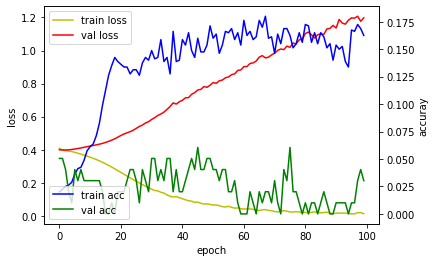

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

이 부분은 모델을 통해서 예측한 번호로 상금을 얼마나 받아갈 수 있을지 알아내보자.

In [39]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)  

[2449890086.4088984, 57201155.05190678, 1451276.5084745763, 52617.561440677964, 5000.0]


등수와 상금을 반환하는 함수

In [40]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

**하나의 함수로부터 공을 뽑아내는 함수**

</br>
예측 번호 생성 방법
확률 높은 공을 뽑을 확률을 높여서 뽑는다.  

출력값 x 100 + 1을 해준 공의 갯수만큼 상자에 넣어서 랜덤하게 하나 뽑기

--> 딥러닝 예측을 반영한 랜덤 뽑기 완성

In [116]:
def gen_numbers_from_probability(nums_prob):

    #gen_box=[i+1 for i in range(45)]
    gen_box=[]
    
    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    for n in range(45):
        ball_count = int(nums_prob[n] * 10 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        gen_box += list(ball)


    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        if len(selected_balls) > 3:
          gen_index = np.random.randint(len(gen_box), size=1)[0]
          ball = gen_box[gen_index]

          if ball not in selected_balls:
              selected_balls.append(ball)  
        else:

          ball_index = np.random.randint(len(ball_box), size=1)[0]
          ball = ball_box[ball_index]

          if ball not in selected_balls:
              selected_balls.append(ball)

    return selected_balls

**검증하는 코드**
</br>
</br>
결과를 보면 훈련데이터를 사용했을 때는 당연히 이 훈련데이터를 사용해서 모델을 만들었기 때문에 받을 수있는 상금이 엄청 높은 것을 알 수가 있다.

</br>
하지만 800회차 이후로는 상금이 뚝 떨어진것을 확인할 수가 있다.


In [117]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): 
        numbers = gen_numbers_from_probability(ys_pred[0]) #뽑기 함수
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   0   0   2   7   1   0       3,275,875
[   2]   2   0   4   4   0   0   4,905,795,749
[   3]   0   1   3   5   1   0      61,823,072
[   4]   0   0   2   5   3   0       3,180,640
[   5]   0   0   2   5   3   0       3,180,640
[   6]   0   0   1   6   2   1       1,776,981
[   7]   0   0   5   3   2   0       7,424,235
[   8]   0   0   5   2   3   0       7,376,617
[   9]   0   0   4   4   2   0       6,025,576
[  10]   0   0   4   6   0   0       6,120,811
[  11]   0   1   4   3   1   1      63,169,113
[  12]   1   0   3   4   2   0   2,454,464,386
[  13]   0   0   3   6   1   0       4,674,534
[  14]   1   0   2   6   1   0   2,453,113,344
[  15]   1   0   2   7   0   0   2,453,160,962
[  16]   1   1   1   7   0   0   2,508,910,840
[  17]   1   1   0   5   3   0   2,507,369,329
[  18]   0   0   4   5   1   0       6,073,193
[  19]   0   0   2   5   2   1       3,175,640
[  20]   0   0   2   6   1   1       3,223,258
[  21]   0   0   5   

위의 결과를 그래프로 출력해보자.


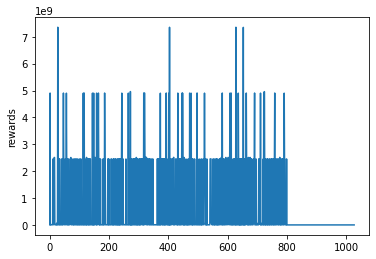

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

이것은 다른 그래프

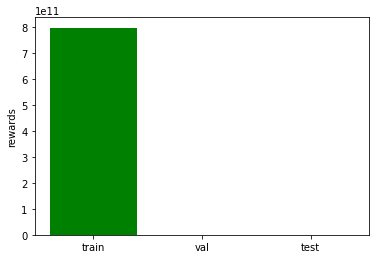

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

사실 우리는 데이터를 훈련셋과 검증셋과 시험셋으로 나눌 필요가 없으므로
모든 데이터를 훈련셋으로 사용해서 다음 로또를 예측해보자.

In [120]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  


epoch    0 train acc 0.142 loss 0.140
epoch    1 train acc 0.136 loss 0.183
epoch    2 train acc 0.137 loss 0.182
epoch    3 train acc 0.138 loss 0.176
epoch    4 train acc 0.137 loss 0.168
epoch    5 train acc 0.139 loss 0.160
epoch    6 train acc 0.140 loss 0.153
epoch    7 train acc 0.142 loss 0.146
epoch    8 train acc 0.143 loss 0.140
epoch    9 train acc 0.145 loss 0.135
epoch   10 train acc 0.146 loss 0.130
epoch   11 train acc 0.147 loss 0.125
epoch   12 train acc 0.149 loss 0.121
epoch   13 train acc 0.150 loss 0.117
epoch   14 train acc 0.151 loss 0.114
epoch   15 train acc 0.152 loss 0.111
epoch   16 train acc 0.153 loss 0.107
epoch   17 train acc 0.153 loss 0.104
epoch   18 train acc 0.154 loss 0.102
epoch   19 train acc 0.154 loss 0.099
epoch   20 train acc 0.154 loss 0.097
epoch   21 train acc 0.155 loss 0.094
epoch   22 train acc 0.155 loss 0.092
epoch   23 train acc 0.156 loss 0.090
epoch   24 train acc 0.156 loss 0.088
epoch   25 train acc 0.157 loss 0.086
epoch   26 t

다음 회차의 로또번호를 예측한 결과

In [139]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [1, 5, 9, 29, 32, 33]
1 : [5, 10, 25, 26, 32, 33]
2 : [10, 13, 17, 27, 29, 32]
3 : [5, 8, 10, 29, 32, 33]
4 : [13, 23, 26, 29, 32, 33]
5 : [5, 21, 24, 27, 32, 33]
6 : [5, 12, 20, 27, 29, 33]
7 : [5, 24, 29, 32, 33, 38]
8 : [5, 10, 29, 33, 42, 45]
9 : [5, 10, 13, 29, 33, 45]
